In [1]:
! pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 167kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
import json
import music21 as mc
import numpy as np

import seaborn as sns
sns.set()

import random
random.seed(20201308)

PATH = 'drive/My Drive/000 STUDIA/MASTER/'
FILENAME = "datasets.zip"

with open(os.path.join(PATH, "parse.json"), "r") as handle:
  parsed_data = json.load(handle)

def name_to_ps(name):
  return mc.pitch.Pitch(name).ps if not name.startswith("R") else -1.0

def ps_to_name(ps):
  return mc.pitch.Pitch(ps).nameWithOctave if ps != -1.0 else "REST"

def unify_note(note):
  name, duration = note.split('_')
  pitch = name_to_ps(name)
  return f"{pitch}_{duration}"

def unify_note_to_pitch(note):
  name, duration = note.split('_')
  return str(name_to_ps(name))

TRUNCATE_CHORD = 4
def unify_chord(chord):
  names, duration = chord.split('_')
  new_names = []
  for name in names.split('.')[:TRUNCATE_CHORD]:
    new_names.append(str(name_to_ps(name)))
  return f"{'+'.join(new_names)}_{duration}"

def unify_chord_to_pitches(chord, octave_invariant=False):
  names, duration = chord.split('_')
  new_names = []
  for name in names.split('.')[:TRUNCATE_CHORD]:
    if octave_invariant:
      new_names.append(str(name_to_ps(name[0])))
    else:
      new_names.append(str(name_to_ps(name)))
  return '+'.join(new_names)

notes_translated = []
for idx, melody in enumerate(parsed_data['notes']):
  notes_translated.append([unify_note_to_pitch(n) for n in melody])

OCTAVE_INVARIANT = True
chords_translated = []
for idx, melody in enumerate(parsed_data['chords']):
  chords_translated.append([unify_chord_to_pitches(n, octave_invariant=OCTAVE_INVARIANT) for n in melody])

print(len(set([ch for chords in chords_translated for ch in chords])))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


294


In [4]:
from collections import Counter

def note_encode(note_name):
  return str(mc.note.Note(note_name).pitch.ps)

def note_decode(note):
  pitch = float(note)
  name = "REST" if pitch == -1.0 else mc.note.Note(pitch).nameWithOctave
  return name

n_counts = Counter([n for note in notes_translated for n in note])
for note, count in n_counts.most_common()[::-1][:10]:
  print(note_decode(note), count)

D8 1
B0 1
G#1 3
C8 4
G1 4
F#1 4
E-1 6
G#7 6
F1 7
A7 8


In [5]:
for note, count in n_counts.most_common()[:10]:
  print(note_decode(note), count)

REST 85855
E4 83408
C4 82803
C5 77188
A4 75203
G4 68349
D4 66719
E5 57426
D5 52662
B4 41237


In [6]:
mc.chord.Chord(['D', 'F#', 'A'])

<music21.chord.Chord D F# A>

In [7]:
def chord_decode(chord):
  decoded = []
  pitches = chord.split('+')
  for p in pitches:
    if p == "-1.0":
      decoded.append("REST")
    else:
      if OCTAVE_INVARIANT:
        decoded.append(mc.note.Note(float(p)).nameWithOctave[0])
      else:
        decoded.append(mc.note.Note(float(p)).nameWithOctave)
  return " ".join(decoded)

ch_counts = Counter([n for note in chords_translated for n in note])
for chord, count in ch_counts.most_common()[::-1][:10]:
  print(chord_decode(chord), count)

G G D E 1
D F G E 1
E E A 1
E G C C 1
C F A C 1
E B C 1
B C G C 1
E B B E 1
E F G B 1
E F B B 1


In [8]:
ch_counts.most_common()[:10]
for chord, count in ch_counts.most_common()[:10]:
  print(chord_decode(chord), count)

A C E 43378
C E G 39316
G B D 38391
F A C 37543
REST 17706
D F A 16468
E G B 15922
F A C E 6911
A C E G 6548
D F A C 6331


# NOTES

In [9]:
from gensim.models import Word2Vec

MODE = "NOTES"
models_dir = os.path.join(PATH, "embeddings", MODE)

SIZE = 100
WINDOW = 8

# train model
model = Word2Vec(notes_translated, size=SIZE, window=WINDOW, min_count=1)

# summarize the loaded model
print(model)

# summarize vocabulary
words = list(model.wv.vocab)

model_file = f"embeddings_{MODE}_size{SIZE}_window{WINDOW}.bin"
model_file = os.path.join(models_dir, model_file)

# save model
print(model_file)
model.save(model_file)

# load model
new_model = Word2Vec.load(model_file)

Word2Vec(vocab=85, size=100, alpha=0.025)
drive/My Drive/000 STUDIA/MASTER/embeddings/NOTES/embeddings_NOTES_size100_window8.bin


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


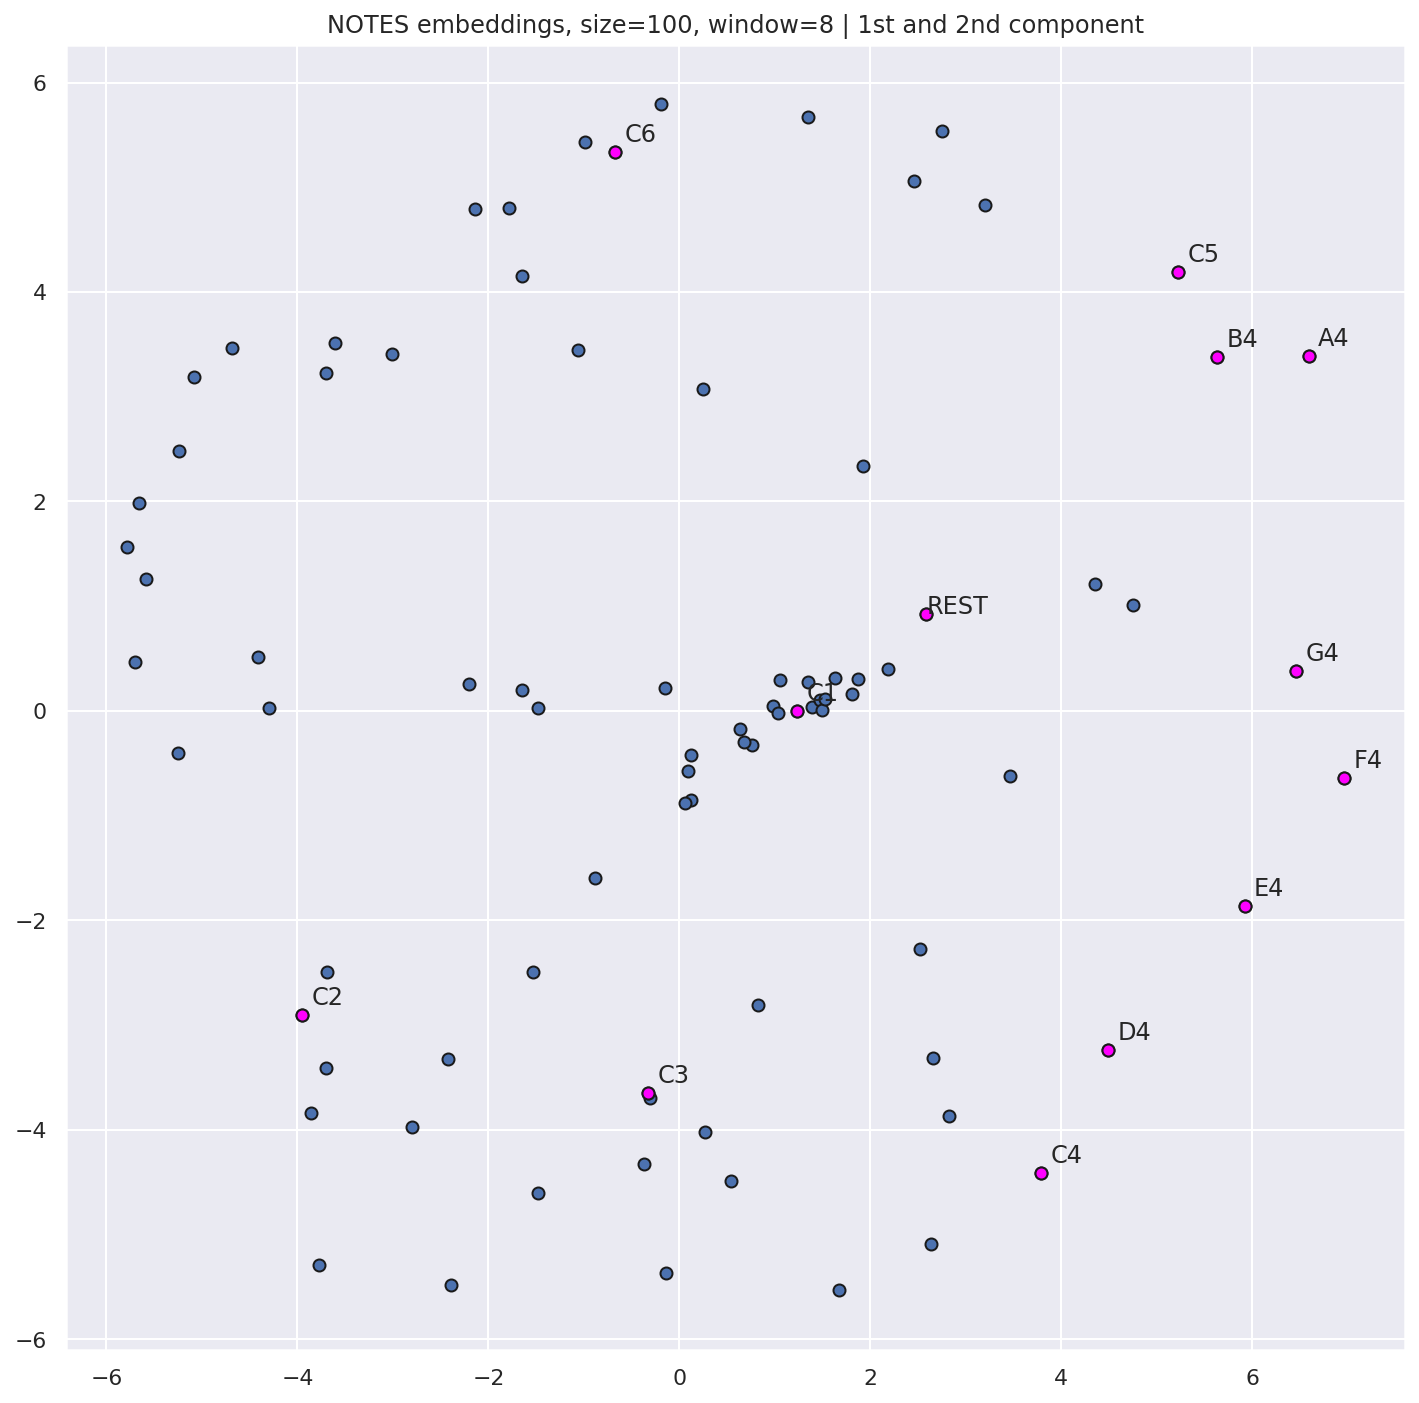

In [10]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import music21 as mc

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

plt.figure(figsize=(12, 12))
plt.scatter(result[:, 0], result[:, 1], edgecolor='k')
words = list(model.wv.vocab)

to_annotate = ["-1.0", "24.0", "36.0", "48.0", "60.0", "62.0", "64.0", "65.0", "67.0", "69.0", "71.0", "72.0", "84.0"]
color_indices = []
for i, word in enumerate(words):
  if any(pitch in word for pitch in to_annotate):
    color_indices.append(i)
    if word == '-1.0':
	    plt.annotate(word.replace('-1.0', 'REST'), xy=(result[i, 0], result[i, 1]))
    else:
      name = mc.note.Note(float(word)).nameWithOctave
      plt.annotate(name, xy=(result[i, 0]+0.1, result[i, 1]+0.1))

plt.scatter(result[color_indices, 0], result[color_indices, 1], edgecolor='k', color='magenta')

plt.title(f"{MODE} embeddings, size={SIZE}, window={WINDOW} | 1st and 2nd component")
plt.savefig(model_file.replace('.bin', '.png'))
plt.show()

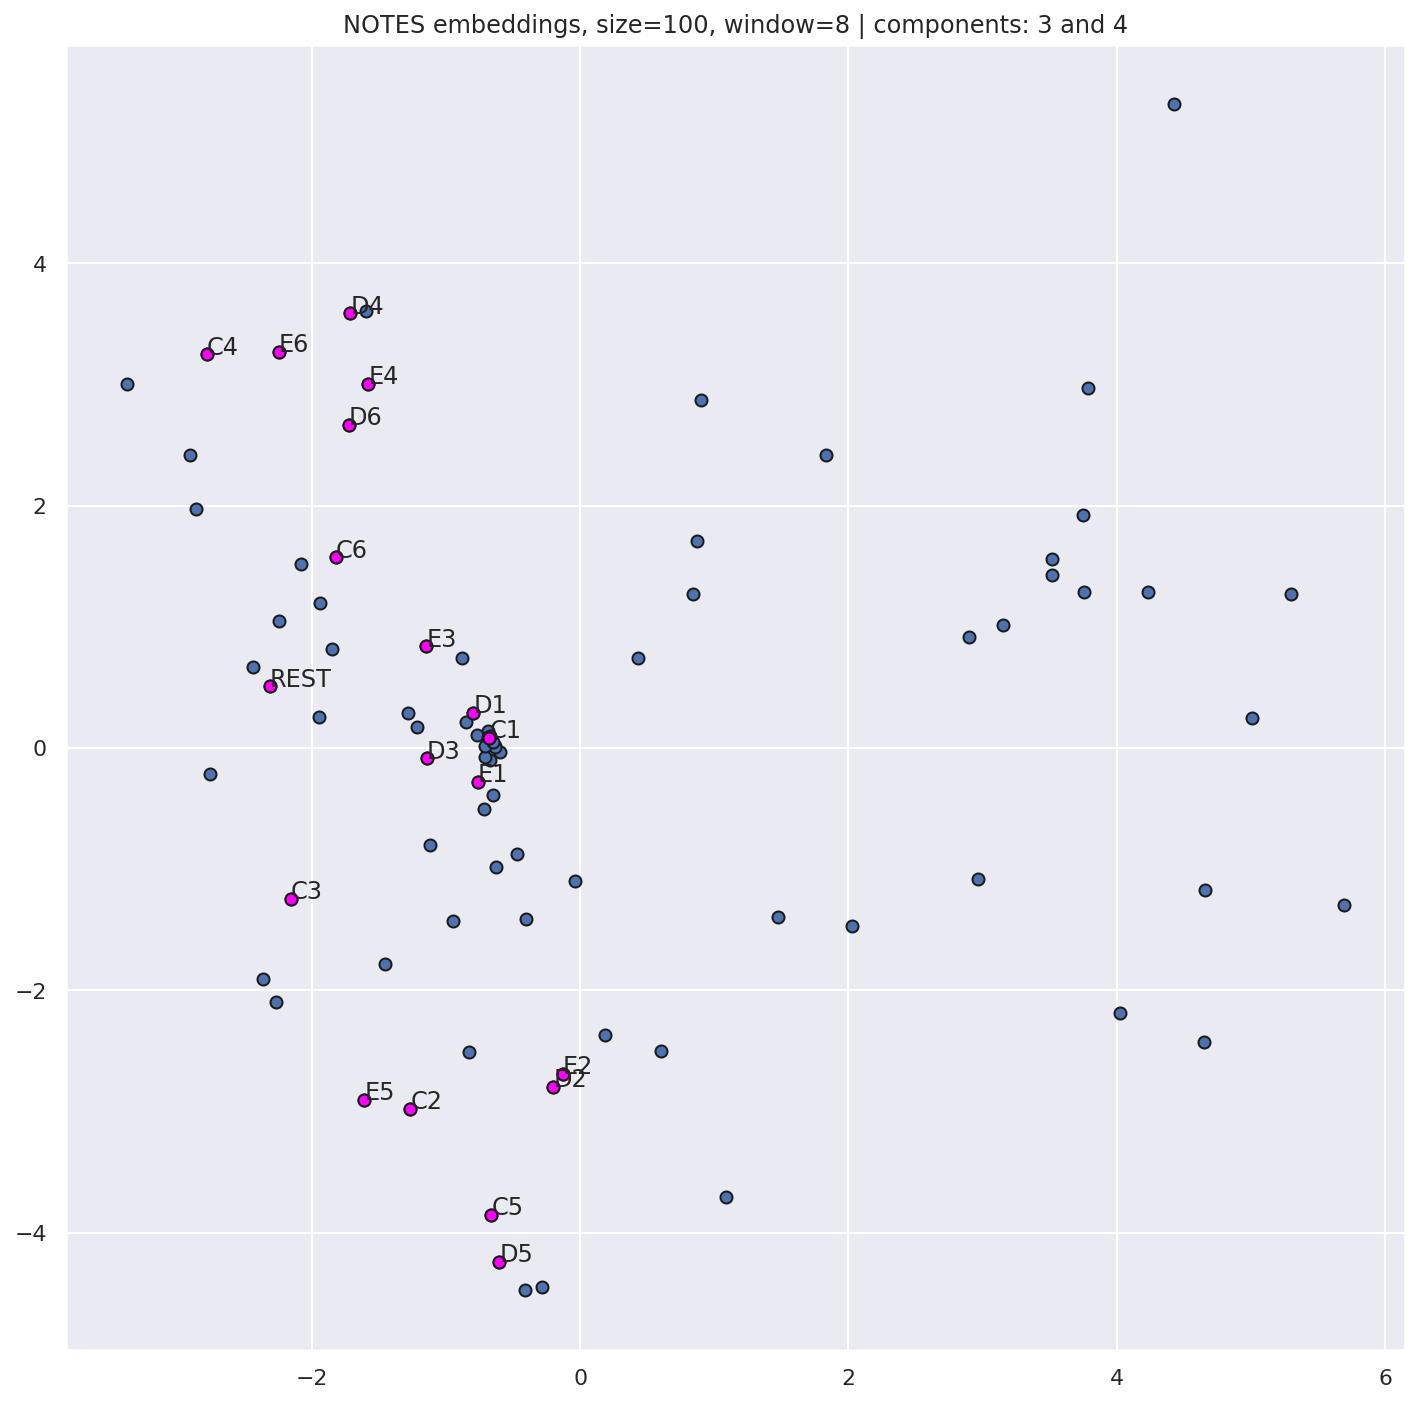

In [11]:
pca = PCA(n_components=4)
comp_1, comp_2 = 2, 3
result = pca.fit_transform(X)
# create a scatter plot of the projection

plt.figure(figsize=(12, 12))
plt.scatter(result[:, comp_1], result[:, comp_2], edgecolor='k')
words = list(model.wv.vocab)

to_annotate = ["-1.0", "24.0", "26.0", "28.0", "36.0", "38.0", "40.0", "48.0", "50.0", "52.0", "60.0", "62.0", "64.0", "72.0", "74.0", "76.0", "84.0", "86.0", "88.0"]
color_indices = []
for i, word in enumerate(words):
  if any(pitch in word for pitch in to_annotate):
    color_indices.append(i)
    if word == '-1.0':
	    plt.annotate(word.replace('-1.0', 'REST'), xy=(result[i, comp_1], result[i, comp_2]))
    else:
      name = mc.note.Note(float(word)).nameWithOctave
      plt.annotate(name, xy=(result[i, comp_1], result[i, comp_2]))

plt.scatter(result[color_indices, comp_1], result[color_indices, comp_2], edgecolor='k', color='magenta')

plt.title(f"{MODE} embeddings, size={SIZE}, window={WINDOW} | components: {comp_1+1} and {comp_2+1}")
plt.savefig(model_file.replace('.bin', '---more.png'))
plt.show()

In [12]:
note_name = "C4"
print(note_name, '\n')
encoded = encode(note_name)

for word, sim in model.wv.similar_by_word(encoded, topn=5):
  print(decode(word), sim)

C4 



NameError: ignored

# CHORDS

In [62]:
MODE = "CHORDS"
models_dir = os.path.join(PATH, "embeddings", MODE)

SIZE = 100
WINDOW = 8

# train model
model = Word2Vec(chords_translated, size=SIZE, window=WINDOW, min_count=5)

# summarize the loaded model
print(model)

# summarize vocabulary
words = list(model.wv.vocab)

model_file = f"embeddings_{MODE}_size{SIZE}_window{WINDOW}.bin"
model_file = os.path.join(models_dir, model_file)

# save model
print(model_file)
model.save(model_file)

# load model
new_model = Word2Vec.load(model_file)

Word2Vec(vocab=230, size=100, alpha=0.025)
drive/My Drive/000 STUDIA/MASTER/embeddings/CHORDS/embeddings_CHORDS_size100_window8.bin


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


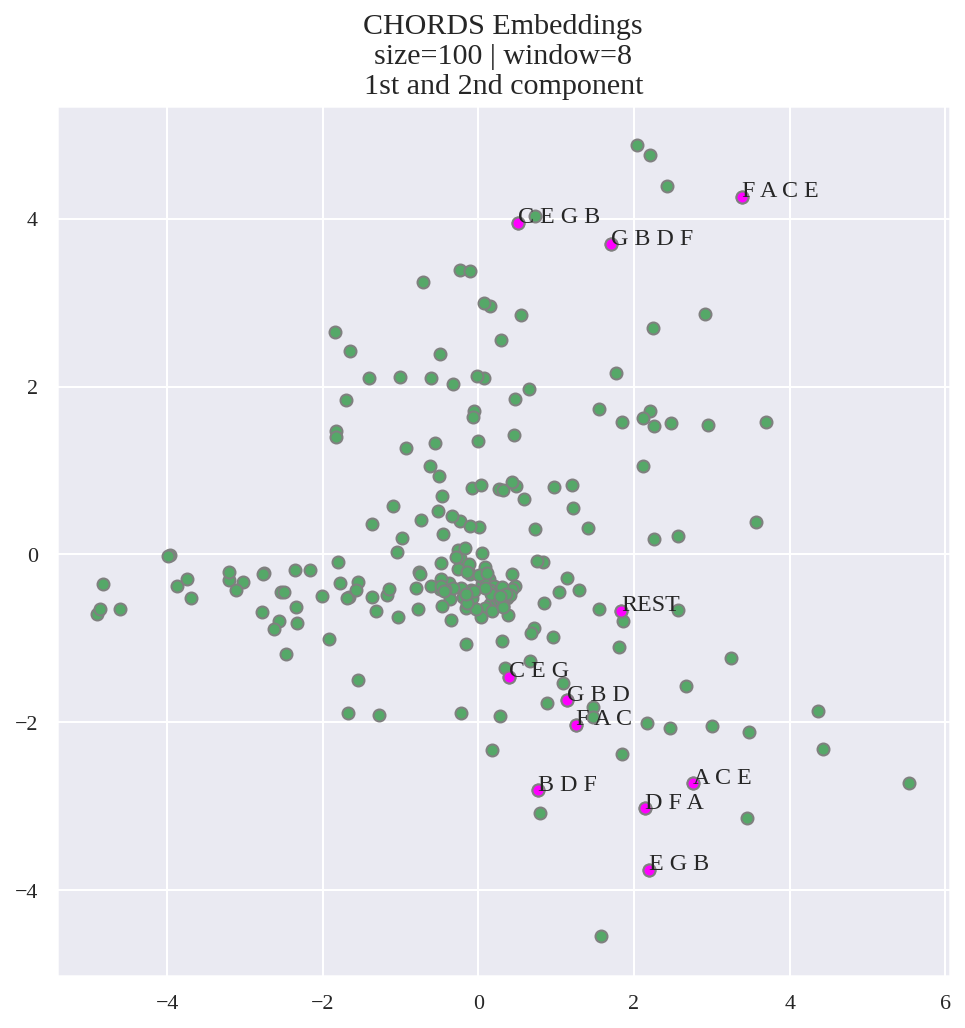

In [63]:
from sklearn.decomposition import PCA
import music21 as mc

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Serif'

X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

plt.figure(figsize=(8, 8))
plt.scatter(result[:, 0], result[:, 1], color='g', edgecolor='gray')
words = list(model.wv.vocab)

to_annotate = ["REST", "C E G", "C E G B", "G B D", "G B D F", "F A C", "F A C E", "D F A", "E G B", "A C E", "B D F"]

color_indices = []

for i, word in enumerate(words):
  dec = chord_decode(word)
  if any(term == dec for term in to_annotate):
    color_indices.append(i)
    plt.annotate(dec, xy=(result[i, 0], result[i, 1]))

plt.scatter(result[color_indices, 0], result[color_indices, 1], edgecolor='gray', color='magenta')

plt.title(f"{MODE} Embeddings\nsize={SIZE} | window={WINDOW}\n1st and 2nd component", size=15)
plt.savefig(model_file.replace('.bin', '.png'))
plt.show()